# Style Transfer

https://harishnarayanan.org/writing/artistic-style-transfer/

In [5]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import time

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
% matplotlib inline

# Seaborn config
import seaborn as sns
sns.set(style='whitegrid', color_codes=True)
sns.set(font_scale=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Images
from IPython.display import Image
from PIL import Image
from io import BytesIO
import requests

# Scipy
import scipy
from scipy.optimize import fmin_l_bfgs_b

# Keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import backend
from keras.preprocessing.image import load_img,img_to_array

# Loading images

In [10]:
base_path = "images/berber-sand-dune_92524_990x742.jpg"
style_path = "images/20170213_135820.jpg"
style_path = "images/hokusai-wave.jpg"

size = (150,170)
# size = (742,990)

height = size[0]
width = size[1]

##### This is the base image

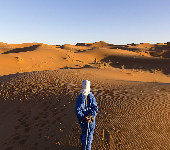

In [11]:
Image.open(base_path).resize((width,height))

##### Style image

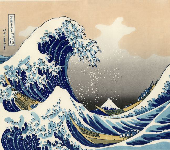

In [12]:
Image.open(style_path).resize((width,height))

# Building model

## Preprocessing

In [13]:
def preprocess_input_manually(img):
    img[:, :, :, 0] -= 103.939
    img[:, :, :, 1] -= 116.779
    img[:, :, :, 2] -= 123.68
    img = img[:, :, :, ::-1]
    return img

In [14]:
def preprocess_image(filename):
    img = scipy.misc.imread(filename,flatten = False)
    img = scipy.misc.imresize(img,(height,width),'cubic')
    img = np.asarray(img,dtype = "float32")
    img = np.expand_dims(img,axis = 0)
#     img = preprocess_input(img)
    img = preprocess_input_manually(img)
    
    return img

In [15]:
base_shape = preprocess_image(base_path).shape
base_shape

(1, 150, 170, 3)

In [16]:
preprocess_image(style_path).shape

(1, 150, 170, 3)

## Prepare the tensors and model
##### Concatenate the two images in a tensor

In [17]:
# Create the three tensors
base_image = backend.variable(preprocess_image(base_path))
style_image = backend.variable(preprocess_image(style_path))
combination_image = backend.placeholder(base_shape)

# Concatenate them
input_tensor = backend.concatenate([base_image,style_image,combination_image],axis = 0)

##### Loading the pre-trained VGG-16 model

In [18]:
model = VGG16(input_tensor = input_tensor,weights='imagenet', include_top=False)

##### Looking at the different layers

In [19]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 150, 170, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 150, 170, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 75, 85, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 75, 85, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 75, 85, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 37, 42, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 37, 42, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 37, 42, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 37, 42, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 18, 21, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 18, 21, 512) dtype=float32>,
 'block4_conv2': 

##### Defining some parameters

In [20]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

## Define the losses

### Initialize the loss

In [21]:
loss = backend.variable(0.)

### Content loss

In [22]:
def calculate_content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

content_loss = content_weight * calculate_content_loss(content_image_features,combination_features)

### Style loss

In [23]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [24]:
def calculate_style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2','block3_conv3', 'block4_conv3','block5_conv3']

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = (style_weight / len(feature_layers)) * calculate_style_loss(style_features, combination_features)

### Variation loss

In [25]:
def calculate_total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

variation_loss = total_variation_weight * calculate_total_variation_loss(combination_image)

### Total loss

In [26]:
loss = loss + style_loss + content_loss + variation_loss

In [27]:
loss

<tf.Tensor 'add_3:0' shape=() dtype=float32>

## Optimization

### Getting the gradient of the generated image with respect to the loss

In [28]:
gradients = backend.gradients(loss,combination_image)
print(gradients)

[<tf.Tensor 'gradients/AddN_4:0' shape=(1, 150, 170, 3) dtype=float32>]


### Define an evaluator

In [29]:
outputs = [loss]
outputs += gradients
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [30]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

### Run the optimizer (L-BGFS) to minimize the loss

In [55]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

xs = [x]

iterations = 10


for i in range(iterations):
    print('Start of iteration', i,end = " - ")
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),fprime=evaluator.grads, maxfun=20)
    xs.append(x)
    print('Current loss value:', min_val ,end = " - ")
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0 - Current loss value: 5.21021e+08 - Iteration 0 completed in 63s
Start of iteration 1 - Current loss value: 2.94772e+08 - Iteration 1 completed in 60s
Start of iteration 2 - Current loss value: 2.38001e+08 - Iteration 2 completed in 60s
Start of iteration 3 - Current loss value: 2.10589e+08 - Iteration 3 completed in 60s
Start of iteration 4 - Current loss value: 1.93961e+08 - Iteration 4 completed in 60s
Start of iteration 5 - Current loss value: 1.80047e+08 - Iteration 5 completed in 60s
Start of iteration 6 - Current loss value: 1.67654e+08 - Iteration 6 completed in 60s
Start of iteration 7 - Current loss value: 1.56058e+08 - Iteration 7 completed in 60s
Start of iteration 8 - Current loss value: 1.47365e+08 - Iteration 8 completed in 60s
Start of iteration 9 - Current loss value: 1.41494e+08 - Iteration 9 completed in 61s


In [56]:
for i in range(1,10):
    x2 = xs[i].reshape((height, width, 3))
    x2 = x2[:, :, ::-1]
    x2[:, :, 0] += 103.939
    x2[:, :, 1] += 116.779
    x2[:, :, 2] += 123.68
    x2 = np.clip(x2, 0, 255).astype('uint8')

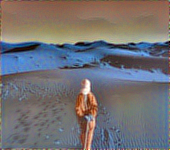

In [71]:
from PIL import Image

Image.fromarray(np.clip(xs[1], 0, 255).reshape((height, width, 3)).astype('uint8'))